In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

In [11]:
%run C:\Users\mvana\Documents\MSc\Temp_O3_H2O\000_Functions.ipynb

In [17]:
# Load data
df = pd.read_csv(r"C:\Users\mvana\Documents\MSc\Temp_O3_H2O\Data\saber_agg.csv")
df['year_month'] = pd.to_datetime(df['year_month']).dt.to_period('M')
df = df.sort_values(['year_month', 'altitude_bin'])

In [18]:
# Pivot: each column is an altitude, each row is a time step
df_pivot = df.pivot(index='year_month', columns='altitude_bin', values='ktemp')
df_pivot = df_pivot.interpolate().dropna(axis=1)  # fill missing

# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_pivot.values)
data = scaled.astype(np.float32)

In [19]:
def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+pred_len])
    return np.array(X), np.array(y)

SEQ_LEN = 24  # past 24 months
PRED_LEN = 18  # forecast next 18 months

X, y = create_sequences(data, SEQ_LEN, PRED_LEN)
X_train, y_train = X[:int(0.8 * len(X))], y[:int(0.8 * len(X))]
X_test, y_test = X[int(0.8 * len(X)):], y[int(0.8 * len(X)):]

In [20]:
X_train.shape

(187, 24, 60)

In [21]:
y_train.shape

(187, 18, 60)

In [22]:
alt_dim = X.shape[2]  # number of altitude levels

# LSTM Model
def build_model(seq_len, alt_dim, pred_len):
    model = models.Sequential([
        layers.Input(shape=(seq_len, alt_dim)),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(pred_len * alt_dim),
        layers.Reshape((pred_len, alt_dim))
    ])
    
    loss_fn = combined_loss_fn(a=0.01, lambda_mse=1.0, lambda_ode=0.5)
    model.compile(optimizer='adam', loss='mae')
    return model

In [23]:
model = build_model(SEQ_LEN, alt_dim, PRED_LEN)

In [24]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=10)
]

In [25]:
history = model.fit(X_train, y_train, epochs=500, verbose=0, validation_data=(X_test, y_test), callbacks=callbacks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


C:\Users\mvana\AppData\Local\Temp\ipykernel_19808\3447848635.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


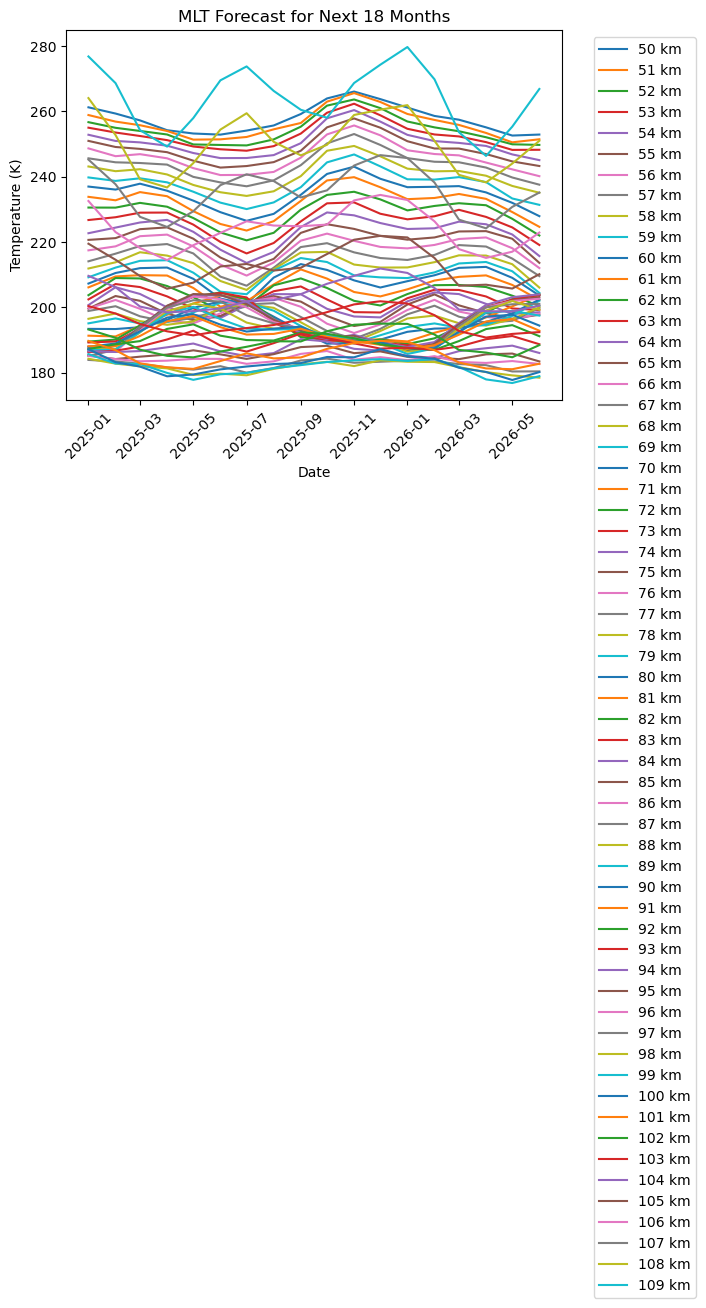

In [26]:
# Use last SEQ_LEN months
last_seq = data[-SEQ_LEN:].reshape(1, SEQ_LEN, alt_dim)
pred_scaled = model.predict(last_seq)[0]
pred = scaler.inverse_transform(pred_scaled)

# Plotting
# Convert Period to Timestamp before adding DateOffset
start_date = df_pivot.index[-1].to_timestamp() + pd.DateOffset(months=1)
months = pd.date_range(start=start_date, periods=PRED_LEN, freq='MS')
for i, alt in enumerate(df_pivot.columns):
    plt.plot(months, pred[:, i], label=f"{alt} km")

plt.title("MLT Forecast for Next 18 Months")
plt.xlabel("Date")
plt.ylabel("Temperature (K)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()
